## 1. Fetching Data

In [16]:
!pip install opendatasets --upgrade --quiet

In [17]:
import pandas as pd
import os
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://kaggle.com/c/tweet-sentiment-extraction/data'

# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  aquibalikhan


Your Kaggle Key:

  ········


100%|██████████████████████████████████████████████████████████████████████████████| 1.39M/1.39M [00:01<00:00, 757kB/s]


Extracting archive .\tweet-sentiment-extraction/tweet-sentiment-extraction.zip to .\tweet-sentiment-extraction


## Data Prep

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = pd.read_csv("tweet-sentiment-extraction/train.csv")
dataset = dataset.dropna(subset=["text", "sentiment"])

dataset = dataset[["text", "sentiment"]]
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Check the dataset sizes
print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train size: 21984, Test size: 5496


In [2]:
# Define the mapping
sentiment_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}

# Map sentiments in both train and test datasets
train_data['sentiment'] = train_data['sentiment'].map(sentiment_mapping)
test_data['sentiment'] = test_data['sentiment'].map(sentiment_mapping)

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [4]:
import torch
from torch.utils.data import Dataset


class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=None, pad_token_id=50256):
        # self.data = pd.read_csv(csv_file)
        self.data = data
        
        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["sentiment"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [5]:
train_dataset = SentimentDataset(
    data=train_data,
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

100


In [6]:
# val_dataset = SentimentDataset(
#     data=dataset['validation'],
#     max_length=train_dataset.max_length,
#     tokenizer=tokenizer
# )
test_dataset = SentimentDataset(
    data=test_data,
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [7]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

# val_loader = DataLoader(
#     dataset=val_dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     drop_last=False,
# )

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [8]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 100])
Label batch dimensions torch.Size([8])


In [9]:
print(f"{len(train_loader)} training batches")
print(f"{len(test_loader)} test batches")

2748 training batches
687 test batches


In [10]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [11]:
from gpt_download import download_and_load_gpt2
from utils import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [12]:
from utils import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Musk's Rocket"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Musk's Rocket Launcher, which is a rocket launcher that can be fired from a rocket launcher


In [18]:
text_2 = (
    "Is the following text 'Sentiment'? Answer with 'neutral' or 'negative' or 'positive': "
    " 'I`d have responded, if I were going"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'Sentiment'? Answer with 'neutral' or 'negative' or 'positive':  'I`d have responded, if I were going to respond, I would have to say something positive. I`d like to be positive.' 'I`d


In [20]:
for param in model.parameters():
    param.requires_grad = False

In [21]:
torch.manual_seed(123)

num_classes = 3
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [22]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

## Sanity Check

In [24]:
inputs = tokenizer.encode("Sooo SAD I will miss you here in San Diego!!")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[   50, 34160,   311,  2885,   314,   481,  2051,   345,   994,   287,
          2986,  9500,  3228]])
Inputs dimensions: torch.Size([1, 13])


In [25]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.7747,  1.3237,  0.0834],
         [-3.7438,  4.0419,  0.8226],
         [-3.7711,  4.1501,  0.4069],
         [-3.6464,  4.4817,  1.5709],
         [-4.9134,  7.1774,  1.8938],
         [-3.7705,  7.2875,  2.9469],
         [-3.0402,  4.9425,  2.4575],
         [-3.8183,  5.4426,  2.0826],
         [-4.2299,  5.3061,  2.5824],
         [-2.6463,  4.5022,  1.7743],
         [-3.3231,  4.1168,  1.7246],
         [-3.9621,  4.5100,  2.2121],
         [-4.3631,  5.0891,  2.2499]]])
Outputs dimensions: torch.Size([1, 13, 3])


In [26]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-4.3631,  5.0891,  2.2499]])


In [27]:
print("Last output token:", outputs[:, -1, :])
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Last output token: tensor([[-4.3631,  5.0891,  2.2499]])
Class label: 1


In [29]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [30]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
# val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
# print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 30.00%
Test accuracy: 27.50%


### Finetune

In [33]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [34]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [36]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    # val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
# print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.806
Test loss: 3.425


In [38]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [39]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(test_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [40]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, test_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.793, Val loss 3.198
Ep 1 (Step 000050): Train loss 0.992, Val loss 1.043
Ep 1 (Step 000100): Train loss 1.087, Val loss 1.090
Ep 1 (Step 000150): Train loss 1.100, Val loss 1.065
Ep 1 (Step 000200): Train loss 1.065, Val loss 1.103
Ep 1 (Step 000250): Train loss 1.086, Val loss 1.106
Ep 1 (Step 000300): Train loss 1.044, Val loss 1.063
Ep 1 (Step 000350): Train loss 1.060, Val loss 1.063
Ep 1 (Step 000400): Train loss 1.073, Val loss 1.052
Ep 1 (Step 000450): Train loss 1.067, Val loss 1.053
Ep 1 (Step 000500): Train loss 1.153, Val loss 1.044
Ep 1 (Step 000550): Train loss 1.127, Val loss 1.127
Ep 1 (Step 000600): Train loss 1.084, Val loss 1.069
Ep 1 (Step 000650): Train loss 1.070, Val loss 1.099
Ep 1 (Step 000700): Train loss 1.100, Val loss 1.116
Ep 1 (Step 000750): Train loss 1.013, Val loss 0.997
Ep 1 (Step 000800): Train loss 1.071, Val loss 0.943
Ep 1 (Step 000850): Train loss 0.970, Val loss 0.949
Ep 1 (Step 000900): Train loss 0.844, Val loss

In [41]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

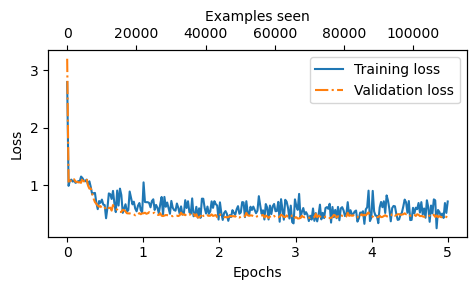

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

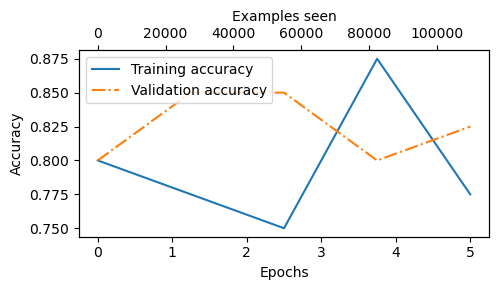

In [43]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [44]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
# val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
# print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 77.92%
Test accuracy: 75.18%


In [45]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    int2label = {0: 'neutral', 1: 'negative', 2: 'positive'}
    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return int2label[predicted_label]

In [50]:
text_1 = (
    "Sooo SAD I will miss you here in San Diego!!!	"
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

negative


In [52]:
torch.save(model.state_dict(), "model/sentiment_classifier.pth")

In [53]:
model_state_dict = torch.load("model/sentiment_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# Load And Use Finetuned Model

In [1]:
from importlib.metadata import version

pkgs = [
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

tiktoken version: 0.8.0
torch version: 2.5.0


In [2]:
from pathlib import Path

finetuned_model_path = Path("model/sentiment_classifier.pth")

In [3]:
from utils import GPTModel


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# Initialize base model
model = GPTModel(BASE_CONFIG)

In [6]:
import torch

# Convert model to classifier as in section 6.5 in ch06.ipynb
num_classes = 3
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

# Then load pretrained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model/sentiment_classifier.pth", map_location=device, weights_only=True))
model.to(device)
model.eval();

In [7]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [10]:
def classify_sentiment(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    int2label = {0: 'neutral', 1: 'negative', 2: 'positive'}
    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return int2label[predicted_label]

In [14]:
text_1 = (
    "Sooo SAD I will miss you here in San Diego!!!"
)

print(classify_sentiment(
    text_1, model, tokenizer, device, max_length=100
))

negative
